In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import math
from PIL import Image

In [257]:
image_path = 'kai_small_dataset/' # small data
labels_limit = 3
img_size = 448
S = 3 #grid
C = 3 #class
batch = 2


In [258]:
labels_df = pd.read_parquet("/Users/kailashkumar/Downloads/week4/easy-500/labels.parquet")
labels_df.head(), labels_df['image_id'].value_counts()

(   image_id    x    y  orientation  radius  class
 0         0  269  450     0.000000      17      0
 1         0  533  299     0.663225      45      1
 2         0  539  427     0.610865      46      1
 3         0  365  148     0.488692      45      1
 4         0  472  136     2.426008      40      1,
 image_id
 0      23
 329    23
 342    23
 341    23
 340    23
        ..
 161    23
 160    23
 159    23
 158    23
 499    23
 Name: count, Length: 500, dtype: int64)

In [259]:
small_df = labels_df[:23*labels_limit]
small_df = small_df.drop('orientation', axis=1)
small_df['width'] = small_df['radius'] *2
small_df['height'] = small_df['radius'] *2
small_df['classes'] = small_df['class']
small_df = small_df.drop('class', axis=1)
small_df = small_df.drop('radius', axis=1)

"""small_df['x'] = small_df['x'] - (small_df['width']/2)
small_df['y'] = small_df['y'] - (small_df['height']/2)"""

small_df[small_df['image_id']==0].tail()

,image_id,x,y,width,height,classes
18,0,362,275,76,76,2
19,0,173,181,82,82,2
20,0,109,297,82,82,2
21,0,934,295,80,80,2
22,0,865,223,80,80,2


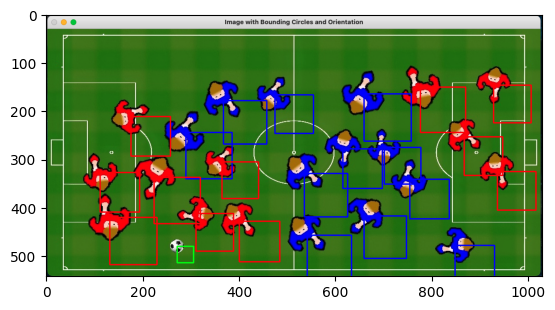

In [128]:
list = small_df.values.tolist()
image_1_labels = list[:23]

image = cv2.imread('/Users/kailashkumar/Downloads/week4/kai_small_dataset/0.jpg')
# Define a dictionary to store the labels for each class
class_labels = {
    0: [],  # Ball
    1: [],  # Team 1
    2: []   # Team 2
    }

# Separate the data into different classes
for id, x, y, width, height, class_id in image_1_labels:
    class_labels[class_id].append((x, y, width, height))

# Define colors for each class
colors = {
    0: (0, 255, 0),   # Green for the ball
    1: (255, 0, 0),   # Blue for Team 1
    2: (0, 0, 255)    # Red for Team 2
}

# Draw bounding circles and orientation lines
for class_id, labels in class_labels.items():
    color = colors[class_id]
    for x, y, width, height in labels:
        # Draw the bounding rectangle
        cv2.rectangle(image, (int(x-(width/2)), int(y-(height/2))), (int(x + width/2), int(y + height/2)), color, 2)

# Display the image with bounding circles and orientation lines
"""cv2.imshow('Image with Bounding Circles and Orientation', image)
cv2.waitKey(0)
cv2.destroyAllWindows()"""

plt.imshow(img.imread('/Users/kailashkumar/Downloads/week4/kai_files/Screenshot 2024-03-27 at 1.46.56 AM.png'));

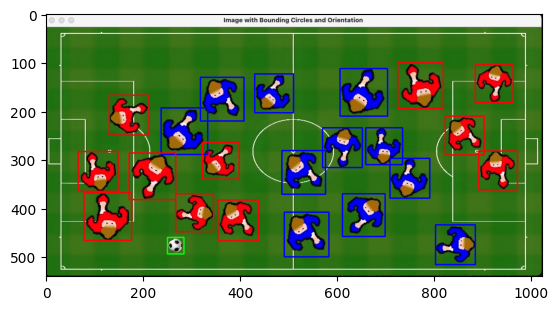

In [129]:
plt.imshow(img.imread('/Users/kailashkumar/Downloads/week4/kai_files/Screenshot 2024-03-27 at 12.11.39 AM.png'));

In [260]:
# Save the DataFrame to a CSV file
csv_file_name = 'annotations.csv'
small_df.to_csv(csv_file_name, index=False)

In [263]:
processed_images = []
processed_annotations = []
adjusted_values_final = []

csv_file = 'annotations.csv'
img_dir = "/Users/kailashkumar/Downloads/week4/kai_small_dataset"


for i in range(labels_limit):
        target_annotation = np.zeros((S, S, 5 + C))     
        # Load and resize the image
        image_path = os.path.join(img_dir, f"{int(i)}.jpg")
        # print(image_path)
        image = Image.open(image_path)
        original_width, original_height = image.size
        # print(image.size)
        image = image.resize((img_size, img_size))
        # Convert image to numpy array
        image_array = np.array(image)

        # Adjust annotation values
        x_ratio = img_size / original_width
        y_ratio = img_size / original_height

        for _,row in small_df[small_df['image_id'] == i].iterrows():
                x, y, width, height, class_label = row[1:]
                adjusted_x = x * x_ratio
                adjusted_y = y * y_ratio
                adjusted_width = width * x_ratio
                adjusted_height = height * y_ratio
                adjusted_values_final.append((i,adjusted_x,adjusted_y,adjusted_width,adjusted_height, class_label))
                
                # Convert coordinates to grid cell format
                grid_x = int(adjusted_x // (img_size // S))
                grid_y = int(adjusted_y // (img_size // S))
                cell_x = (adjusted_x % (img_size // S)) / (img_size // S)
                cell_y = (adjusted_y % (img_size // S)) / (img_size // S)
                cell_width = adjusted_width / (img_size / S)
                cell_height = adjusted_height / (img_size / S)

                # Create target annotation tensor
                target_annotation[grid_y, grid_x, 0:4] = [cell_x, cell_y, cell_width, cell_height]
                target_annotation[grid_y, grid_x, 4] = 1
                target_annotation[grid_y, grid_x, 5 + int(class_label)] = 1
        
        processed_images.append(image_array)
        processed_annotations.append(target_annotation)
   
processed_images = np.array(processed_images)
processed_annotations = np.array(processed_annotations)
adjusted_values_final = np.array(adjusted_values_final)

# Print the shapes of the processed data
print("Processed Images Shape:", processed_images.shape)
print("Processed Annotations Shape:", processed_annotations.shape)
adjusted_values_final.shape


Processed Images Shape: (3, 448, 448, 3)
Processed Annotations Shape: (3, 3, 3, 8)
[[[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.92911074 0.78691275 0.28710938 0.57421875 1.         0.
   1.         0.        ]
  [0.27265101 0.70469799 0.27539062 0.55078125 1.         0.
   0.         1.        ]]

 [[0.32005034 0.74412752 0.24023437 0.48046875 1.         0.
   1.         1.        ]
  [0.06291946 0.61493289 0.22265625 0.4453125  1.         0.
   1.         1.        ]
  [0.53984899 0.30956376 0.234375   0.46875    1.         0.
   1.         1.        ]]

 [[0.37877517 0.29026846 0.28710938 0.57421875 1.         1.
   0.         1.        ]
  [0.16862416 0.33724832 0.24609375 0.4921875  1.         0.
   1.         1.        ]
  [0.4840604  0.63087248 0.24023437 0.48046875 1.         0.
   1.         0.        ]]]


In [272]:
for i in processed_annotations[0].tolist():
    for j in i:
        print(f"{j}\n")

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.9291107382550335, 0.7869127516778524, 0.287109375, 0.57421875, 1.0, 0.0, 1.0, 0.0]

[0.2726510067114094, 0.7046979865771812, 0.275390625, 0.55078125, 1.0, 0.0, 0.0, 1.0]

[0.3200503355704698, 0.7441275167785235, 0.24023437499999997, 0.48046874999999994, 1.0, 0.0, 1.0, 1.0]

[0.06291946308724833, 0.6149328859060402, 0.22265624999999997, 0.44531249999999994, 1.0, 0.0, 1.0, 1.0]

[0.5398489932885906, 0.30956375838926176, 0.23437499999999997, 0.46874999999999994, 1.0, 0.0, 1.0, 1.0]

[0.3787751677852349, 0.2902684563758389, 0.287109375, 0.57421875, 1.0, 1.0, 0.0, 1.0]

[0.1686241610738255, 0.337248322147651, 0.24609374999999997, 0.49218749999999994, 1.0, 0.0, 1.0, 1.0]

[0.48406040268456374, 0.6308724832214765, 0.24023437499999997, 0.48046874999999994, 1.0, 0.0, 1.0, 0.0]



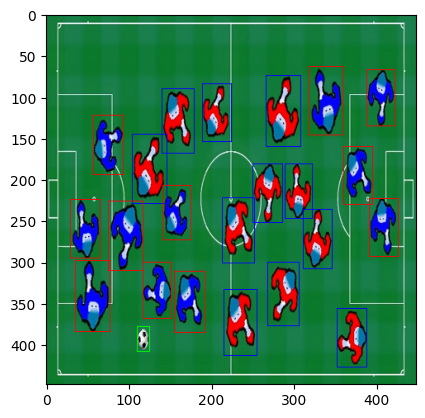

In [132]:
image_count = 0
def plot_labels_on_image(image, labels):
    # Create a copy of the image for drawing
    image_with_labels = image.copy()
    for _, x, y, w, h, class_label in labels:
        # Calculate bounding box coordinates
        x1 = int(x - w/2) 
        y1 = int(y - h/2)
        x2 = int(x + w/2)
        y2 = int(y + h/2) 

        if class_label==0:
            color = (0, 255, 0)
        elif class_label ==1:
            color = (255, 0, 0)
        elif class_label ==2:
            color = (0, 0, 255)

        # Draw the bounding box
        cv2.rectangle(image_with_labels, (x1, y1), (x2, y2), color, 1)

    # Display the image
    plt.imshow(cv2.cvtColor(image_with_labels, cv2.COLOR_BGR2RGB)) 
    plt.show()

plot_labels_on_image(processed_images[image_count], adjusted_values_final[(image_count*23):(image_count*23)+23])

In [133]:
processed_images = []
processed_annotations = []
adjusted_values_final = []
csv_file = 'annotations.csv'
img_dir = "/Users/kailashkumar/Downloads/week4/kai_small_dataset"

for i in range(labels_limit):
    target_annotation = np.zeros((S, S, 5 + C))
    
    # Load and resize the image
    image_path = os.path.join(img_dir, f"{int(i)}.jpg")
    image = Image.open(image_path)
    original_width, original_height = image.size
    image = image.resize((img_size, img_size))
    
    # Convert image to numpy array and normalize pixel values
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    # image_array = (np.array(image) / 255.0) - 0.5  # Normalize to [-1, 1]
    
    # Adjust annotation values
    x_ratio = img_size / original_width
    y_ratio = img_size / original_height
    
    for _,row in small_df[small_df['image_id'] == i].iterrows():
        x, y, width, height, class_label = row[1:]
        adjusted_x = x * x_ratio / img_size  # Normalize x coordinate
        adjusted_y = y * y_ratio / img_size  # Normalize y coordinate
        adjusted_width = width * x_ratio / img_size  # Normalize width
        adjusted_height = height * y_ratio / img_size  # Normalize height
        adjusted_values_final.append((i, adjusted_x, adjusted_y, adjusted_width, adjusted_height, class_label))
        
        # Convert coordinates to grid cell format
        grid_x = int(adjusted_x * S)
        grid_y = int(adjusted_y * S)
        cell_x = (adjusted_x * S) % 1
        cell_y = (adjusted_y * S) % 1
        cell_width = adjusted_width * S
        cell_height = adjusted_height * S
        
        # Create target annotation tensor
        target_annotation[grid_y, grid_x, 0:4] = [cell_x, cell_y, cell_width, cell_height]
        target_annotation[grid_y, grid_x, 4] = 1
        target_annotation[grid_y, grid_x, 5 + int(class_label)] = 1
    
    processed_images.append(image_array)
    processed_annotations.append(target_annotation)

processed_images = np.array(processed_images)
processed_annotations = np.array(processed_annotations)
adjusted_values_final = np.array(adjusted_values_final)

# Print the shapes of the processed data
print("Processed Images Shape:", processed_images.shape)
print("Processed Annotations Shape:", processed_annotations.shape)
processed_images[0] ,processed_annotations[0]

Processed Images Shape: (50, 448, 448, 3)
Processed Annotations Shape: (50, 7, 7, 8)


(array([[[0.22745098, 0.48627451, 0.07058824],
         [0.22745098, 0.48627451, 0.07058824],
         [0.22352941, 0.48235294, 0.06666667],
         ...,
         [0.29019608, 0.49019608, 0.09411765],
         [0.29411765, 0.49411765, 0.09803922],
         [0.29411765, 0.49411765, 0.09803922]],
 
        [[0.22745098, 0.48627451, 0.07058824],
         [0.22352941, 0.48235294, 0.06666667],
         [0.22745098, 0.48627451, 0.07058824],
         ...,
         [0.29411765, 0.49411765, 0.09803922],
         [0.29411765, 0.49411765, 0.09803922],
         [0.29019608, 0.49019608, 0.09411765]],
 
        [[0.23137255, 0.49019608, 0.0745098 ],
         [0.22352941, 0.48235294, 0.06666667],
         [0.22745098, 0.48627451, 0.07058824],
         ...,
         [0.29411765, 0.49411765, 0.09803922],
         [0.29019608, 0.49019608, 0.09411765],
         [0.29019608, 0.49019608, 0.09411765]],
 
        ...,
 
        [[0.17254902, 0.47843137, 0.03921569],
         [0.17254902, 0.47843137, 0.03921

In [134]:
class YoloDataset(Dataset):
    def __init__(self, images, annotations):
        self.images = images
        self.annotations = annotations
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        
        annotation = self.annotations[idx]
        return {'images' : image, 'annotations' : annotation}
    
dataset = YoloDataset(processed_images, processed_annotations)
dataloader = DataLoader(dataset, batch_size = 4)

for batch in dataloader:
    images, annotations = batch['images'], batch['annotations']
    print(images.shape)
    print(annotations.shape)


torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])


torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 8])
torch.Size([2, 3, 448, 448])
torch.Size([2, 7, 7, 8])


In [66]:
############################################################################################################

In [82]:
# Try 1
# Choose big architecture as the paper and the object loss starts to fade

class YOLOv1(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 192, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 3*3*(num_boxes*5 + num_classes)),
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(-1, 3, 3, self.num_boxes*5 + self.num_classes)
        return x


In [83]:
# Try 1
# Choose big architecture as the paper and the object loss starts to fade

def yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj):
    batch_size = predictions.size(0)
    s = 3  # Grid size, assuming 7x7 grid
    C = num_classes  # Number of classes

    # Unpack predictions and targets
    predictions = predictions.view(batch_size, s, s, 5 + C)
    boxes_pred = predictions[..., :5]
    classes_pred = predictions[..., 5:]

    coord_mask = targets[..., 0] > 0  # Mask for object presence
    noobj_mask = targets[..., 0] == 0  # Mask for no object

    targets = targets[..., 1:]  # Remove the object presence flag
    
    target_boxes = targets[..., :5]  # Ground truth bounding boxes
    target_classes = targets[..., 5:]  # Ground truth classes

    # Calculate the coordinate loss
    coord_loss = lambda_coord * F.mse_loss(boxes_pred[coord_mask], target_boxes[coord_mask])
    print(f"coord_loss: {coord_loss}")

    # Calculate the object confidence loss
    obj_loss = F.mse_loss(boxes_pred[..., 4][coord_mask], targets[..., 4][coord_mask])
    print(f"obj_loss: {obj_loss}")

    # Calculate the no-object confidence loss
    noobj_loss = lambda_noobj * F.mse_loss(boxes_pred[..., 4][noobj_mask], targets[..., 4][noobj_mask])
    print(f"noobj_loss: {noobj_loss}")

    # Calculate the class probability loss
    class_loss = F.cross_entropy(classes_pred[coord_mask].view(-1, C), target_classes[coord_mask].argmax(-1))
    print(f"class_loss: {class_loss}")

    # Combine all losses
    total_loss = coord_loss + obj_loss + noobj_loss + class_loss
    print(f"\ntotal_loss: {total_loss}")

    return total_loss

# Hyperparameters
num_classes = 3
num_boxes = 1
lambda_coord = 5
lambda_noobj = 0.5
num_epochs = 1
learning_rate = 0.001

# Create the YOLOv1 model
model = YOLOv1(num_classes, num_boxes).float()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        images, targets = batch['images'].float(), batch['annotations'].float()
        optimizer.zero_grad()
        
        predictions = model(images)
        #print(predictions.shape)
        loss = yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj)
        loss.backward()
        print("--- backwards done ----")
        optimizer.step()
        print("--- weights updated ------\n")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


torch.Size([2, 3, 3, 8])
coord_loss: 1.8456308841705322
obj_loss: 0.11818798631429672
noobj_loss: 1.2170004083600361e-05
class_loss: 1.0987954139709473

total_loss: 3.062626361846924
--- backwards done ----
--- weights updated ------
torch.Size([2, 3, 3, 8])
coord_loss: 2.574370861053467
obj_loss: 0.9896740317344666
noobj_loss: nan
class_loss: 0.8467566967010498

total_loss: nan
--- backwards done ----
--- weights updated ------
Epoch [1/1], Loss: nan


In [92]:
# Try 2 - much smaller structure with batch normalisation

class YOLOv1(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(192, 128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        
        # Calculate the output size of the convolutional layers
        conv_output_size = self._calculate_conv_output_size((3, 448, 448))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 3*3*(num_boxes*5 + num_classes)),
        )
    
    def _calculate_conv_output_size(self, input_size):
        # Create a dummy input tensor to pass through the convolutional layers
        x = torch.zeros(1, *input_size)
        x = self.conv_layers(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(-1, 3, 3, self.num_boxes*5 + self.num_classes)
        return x

In [93]:
# Try 2 - much smaller structure with batch normalisation
# Choose big architecture as the paper and the object loss starts to fade

def yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj):
    batch_size = predictions.size(0)
    s = 3  # Grid size, assuming 7x7 grid
    C = num_classes  # Number of classes

    # Unpack predictions and targets
    predictions = predictions.view(batch_size, s, s, 5 + C)
    boxes_pred = predictions[..., :5]
    classes_pred = predictions[..., 5:]

    coord_mask = targets[..., 0] > 0  # Mask for object presence
    noobj_mask = targets[..., 0] == 0  # Mask for no object

    targets = targets[..., 1:]  # Remove the object presence flag
    
    target_boxes = targets[..., :5]  # Ground truth bounding boxes
    target_classes = targets[..., 5:]  # Ground truth classes

    # Calculate the coordinate loss
    coord_loss = lambda_coord * F.mse_loss(boxes_pred[coord_mask], target_boxes[coord_mask])
    print(f"coord_loss: {coord_loss}")

    # Calculate the object confidence loss
    obj_loss = F.mse_loss(boxes_pred[..., 4][coord_mask], targets[..., 4][coord_mask])
    print(f"obj_loss: {obj_loss}")

    # Calculate the no-object confidence loss
    noobj_loss = lambda_noobj * F.mse_loss(boxes_pred[..., 4][noobj_mask], targets[..., 4][noobj_mask])
    print(f"noobj_loss: {noobj_loss}")

    # Calculate the class probability loss
    class_loss = F.cross_entropy(classes_pred[coord_mask].view(-1, C), target_classes[coord_mask].argmax(-1))
    print(f"class_loss: {class_loss}")

    # Combine all losses
    total_loss = coord_loss + obj_loss + noobj_loss + class_loss
    print(f"\ntotal_loss: {total_loss}")

    return total_loss

# Hyperparameters
num_classes = 3
num_boxes = 1
lambda_coord = 5
lambda_noobj = 0.5
num_epochs = 1
learning_rate = 0.001

# Create the YOLOv1 model
model = YOLOv1(num_classes, num_boxes).float()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        images, targets = batch['images'].float(), batch['annotations'].float()
        optimizer.zero_grad()
        
        predictions = model(images)
        #print(predictions.shape)
        loss = yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj)
        loss.backward()
        print("--- backwards done ----")
        optimizer.step()
        print("--- weights updated ------\n")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


coord_loss: 1.7851004600524902
obj_loss: 0.13816219568252563
noobj_loss: 0.00982100609689951
class_loss: 1.1047303676605225

total_loss: 3.037814140319824
--- backwards done ----
--- weights updated ------

coord_loss: 19.284257888793945
obj_loss: 5.1341023445129395
noobj_loss: nan
class_loss: 0.6931943893432617

total_loss: nan
--- backwards done ----
--- weights updated ------

Epoch [1/1], Loss: nan


In [108]:
# Try 3 - much smaller structure with batch normalisation - Adding normalization to data - adding more grids - 3 to 7

class YOLOv1(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(192, 128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        
        # Calculate the output size of the convolutional layers
        conv_output_size = self._calculate_conv_output_size((3, 448, 448))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 7*7*(num_boxes*5 + num_classes)),
        )
    
    def _calculate_conv_output_size(self, input_size):
        # Create a dummy input tensor to pass through the convolutional layers
        x = torch.zeros(1, *input_size)
        x = self.conv_layers(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(-1, 7, 7, self.num_boxes*5 + self.num_classes)
        return x

In [123]:
# Try 2 - much smaller structure with batch normalisation - Adding normalization to data - adding more grids - 3 to 7

def yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj):
    batch_size = predictions.size(0)
    s = 7  # Grid size, assuming 7x7 grid
    C = num_classes  # Number of classes

    # Unpack predictions and targets
    predictions = predictions.view(batch_size, s, s, 5 + C)
    boxes_pred = predictions[..., :5]
    classes_pred = predictions[..., 5:]

    coord_mask = targets[..., 0] > 0  # Mask for object presence
    noobj_mask = targets[..., 0] == 0  # Mask for no object

    targets = targets[..., 1:]  # Remove the object presence flag
    
    target_boxes = targets[..., :5]  # Ground truth bounding boxes
    target_classes = targets[..., 5:]  # Ground truth classes

    # Calculate the coordinate loss
    coord_loss = lambda_coord * F.mse_loss(boxes_pred[coord_mask], target_boxes[coord_mask])
    print(f"coord_loss: {coord_loss}")

    # Calculate the object confidence loss
    obj_loss = F.mse_loss(boxes_pred[..., 4][coord_mask], targets[..., 4][coord_mask])
    print(f"obj_loss: {obj_loss}")

    # Calculate the no-object confidence loss
    noobj_loss = lambda_noobj * F.mse_loss(boxes_pred[..., 4][noobj_mask], targets[..., 4][noobj_mask])
    print(f"noobj_loss: {noobj_loss}")

    # Calculate the class probability loss
    class_loss = F.cross_entropy(classes_pred[coord_mask].view(-1, C), target_classes[coord_mask].argmax(-1))
    print(f"class_loss: {class_loss}")

    # Combine all losses
    total_loss = coord_loss + obj_loss + noobj_loss + class_loss
    print(f"\ntotal_loss: {total_loss}\n")

    return total_loss

# Hyperparameters
num_classes = 3
num_boxes = 1
lambda_coord = 5
lambda_noobj = 0.5
num_epochs = 5
learning_rate = 0.001

# Create the YOLOv1 model
model = YOLOv1(num_classes, num_boxes).float()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        images, targets = batch['images'].float(), batch['annotations'].float()
        optimizer.zero_grad()
        
        predictions = model(images)
        #print(predictions.shape)
        loss = yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj)
        loss.backward()
        print("--- backwards done ----")
        optimizer.step()
        print("--- weights updated ------\n")
    
    print(f"######## Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()} #######\n")


coord_loss: 3.0413148403167725
obj_loss: 0.08104512840509415
noobj_loss: 0.009055117145180702
class_loss: 1.0882617235183716

total_loss: 4.219676971435547

--- backwards done ----
--- weights updated ------

coord_loss: 7.590139389038086
obj_loss: 0.9347245693206787
noobj_loss: 0.6691530346870422
class_loss: 1.3709841966629028

total_loss: 10.565001487731934

--- backwards done ----
--- weights updated ------

######## Epoch [1/5], Loss: 10.565001487731934#######

coord_loss: 10.113227844238281
obj_loss: 3.4557082653045654
noobj_loss: 0.7714272737503052
class_loss: 1.4882776737213135

total_loss: 15.828640937805176

--- backwards done ----
--- weights updated ------

coord_loss: 6.863750457763672
obj_loss: 1.4941352605819702
noobj_loss: 0.3380955755710602
class_loss: 1.0430973768234253

total_loss: 9.739078521728516

--- backwards done ----
--- weights updated ------

######## Epoch [2/5], Loss: 9.739078521728516#######

coord_loss: 5.791744709014893
obj_loss: 2.093447208404541
noobj_

In [136]:
# Try 4
# much smaller structure with batch normalisation  
# Adding normalization to data
# adding more grids - 3 to 7
# Increasing batch size and total number of images by 10 times
# 50 images , 4 batches

class YOLOv1(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(192, 128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        
        # Calculate the output size of the convolutional layers
        conv_output_size = self._calculate_conv_output_size((3, 448, 448))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 7*7*(num_boxes*5 + num_classes)),
        )
    
    def _calculate_conv_output_size(self, input_size):
        # Create a dummy input tensor to pass through the convolutional layers
        x = torch.zeros(1, *input_size)
        x = self.conv_layers(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(-1, 7, 7, self.num_boxes*5 + self.num_classes)
        return x

# Try 2 - much smaller structure with batch normalisation - Adding normalization to data - adding more grids - 3 to 7

def yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj):
    batch_size = predictions.size(0)
    s = 7  # Grid size, assuming 7x7 grid
    C = num_classes  # Number of classes

    # Unpack predictions and targets
    predictions = predictions.view(batch_size, s, s, 5 + C)
    boxes_pred = predictions[..., :5]
    classes_pred = predictions[..., 5:]

    coord_mask = targets[..., 0] > 0  # Mask for object presence
    noobj_mask = targets[..., 0] == 0  # Mask for no object

    targets = targets[..., 1:]  # Remove the object presence flag
    
    target_boxes = targets[..., :5]  # Ground truth bounding boxes
    target_classes = targets[..., 5:]  # Ground truth classes

    # Calculate the coordinate loss
    coord_loss = lambda_coord * F.mse_loss(boxes_pred[coord_mask], target_boxes[coord_mask])
    #print(f"coord_loss: {coord_loss}")

    # Calculate the object confidence loss
    obj_loss = F.mse_loss(boxes_pred[..., 4][coord_mask], targets[..., 4][coord_mask])
    #print(f"obj_loss: {obj_loss}")

    # Calculate the no-object confidence loss
    noobj_loss = lambda_noobj * F.mse_loss(boxes_pred[..., 4][noobj_mask], targets[..., 4][noobj_mask])
    #print(f"noobj_loss: {noobj_loss}")

    # Calculate the class probability loss
    class_loss = F.cross_entropy(classes_pred[coord_mask].view(-1, C), target_classes[coord_mask].argmax(-1))
    #print(f"class_loss: {class_loss}")

    # Combine all losses
    total_loss = coord_loss + obj_loss + noobj_loss + class_loss
    #print(f"\ntotal_loss: {total_loss}\n")

    return total_loss

# Hyperparameters
num_classes = 3
num_boxes = 1
lambda_coord = 5
lambda_noobj = 0.5
num_epochs = 20
learning_rate = 0.001

# Create the YOLOv1 model
model = YOLOv1(num_classes, num_boxes).float()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        images, targets = batch['images'].float(), batch['annotations'].float()
        optimizer.zero_grad()
        
        predictions = model(images)
        #print(predictions.shape)
        loss = yolo_v1_loss(predictions, targets, num_classes, lambda_coord, lambda_noobj)
        loss.backward()
        #print("--- backwards done ----")
        optimizer.step()
        #print("--- weights updated ------\n")
    
    print(f"######## Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}")


######## Epoch [1/20], Loss: 2.18584
######## Epoch [2/20], Loss: 1.59591
######## Epoch [3/20], Loss: 1.08475
######## Epoch [4/20], Loss: 0.98354
######## Epoch [5/20], Loss: 0.85204
######## Epoch [6/20], Loss: 0.99107
######## Epoch [7/20], Loss: 1.18161
######## Epoch [8/20], Loss: 1.06857
######## Epoch [9/20], Loss: 0.97881
######## Epoch [10/20], Loss: 0.76883
######## Epoch [11/20], Loss: 1.01961
######## Epoch [12/20], Loss: 0.93492
######## Epoch [13/20], Loss: 1.02530
######## Epoch [14/20], Loss: 0.92468
######## Epoch [15/20], Loss: 0.70616
######## Epoch [16/20], Loss: 0.70241
######## Epoch [17/20], Loss: 1.22467
######## Epoch [18/20], Loss: 0.63620
######## Epoch [19/20], Loss: 0.49654
######## Epoch [20/20], Loss: 0.40840


In [164]:
predictions[0]

tensor([[[ 8.0541e-01,  4.4005e-01,  9.2279e-01,  9.2687e-01, -9.3400e-02,
           7.5773e-01,  3.1906e-01, -5.0594e+00],
         [ 8.9115e-01,  3.6626e-01,  1.1676e+00,  7.9547e-01,  1.5560e-01,
           1.1832e+00,  6.0005e-02, -5.1955e+00],
         [ 9.1058e-01,  5.7594e-01,  1.1022e+00,  1.2205e+00, -4.4103e-02,
          -6.0293e-01,  8.5009e-01, -6.3537e+00],
         [ 7.8278e-01,  9.1701e-01,  1.1027e+00,  8.1816e-01, -7.4345e-02,
           5.4630e-01,  9.4066e-01, -5.7838e+00],
         [ 8.5405e-01,  4.1852e-01,  9.5540e-01,  6.9850e-01,  3.6831e-01,
           1.5582e+00,  3.2932e-01, -4.8223e+00],
         [ 9.3081e-01,  5.5535e-01,  8.2293e-01,  6.9557e-01,  1.3188e-01,
           7.0002e-01,  8.9793e-01, -4.9774e+00],
         [ 6.6307e-01,  5.2331e-01,  9.2097e-01,  8.9215e-01, -1.6881e-01,
           8.6574e-01,  7.9431e-01, -4.6540e+00]],

        [[ 4.2473e-01,  5.9425e-01,  1.3040e+00,  9.4100e-01, -6.2749e-02,
           8.7804e-02,  1.2027e+00, -5.1715e+00]

boxes:
tensor([[[[ 0.8054,  0.4400,  0.9228,  0.9269],
          [ 0.8911,  0.3663,  1.1676,  0.7955],
          [ 0.9106,  0.5759,  1.1022,  1.2205],
          [ 0.7828,  0.9170,  1.1027,  0.8182],
          [ 0.8541,  0.4185,  0.9554,  0.6985],
          [ 0.9308,  0.5553,  0.8229,  0.6956],
          [ 0.6631,  0.5233,  0.9210,  0.8921]],

         [[ 0.4247,  0.5942,  1.3040,  0.9410],
          [ 0.5216,  0.7747,  0.9543,  1.0704],
          [ 0.3920,  0.4823,  1.0087,  0.9119],
          [ 0.2257,  0.6838,  1.0141,  0.8791],
          [ 0.4329,  0.3678,  1.0941,  1.1916],
          [ 0.3963,  0.6445,  1.0939,  1.1505],
          [ 0.4011,  0.4374,  1.2808,  1.2807]],

         [[ 0.7446,  0.5024,  0.9161,  0.8208],
          [ 0.4989,  0.5107,  1.0913,  0.8648],
          [ 0.3758,  0.4694,  1.0330,  0.9333],
          [ 0.7555,  0.5751,  1.1916,  0.9685],
          [ 0.6341,  0.6468,  1.2053,  0.7388],
          [ 0.1783,  0.7998,  1.0747,  0.7834],
          [ 0.5442,  0.4419, 

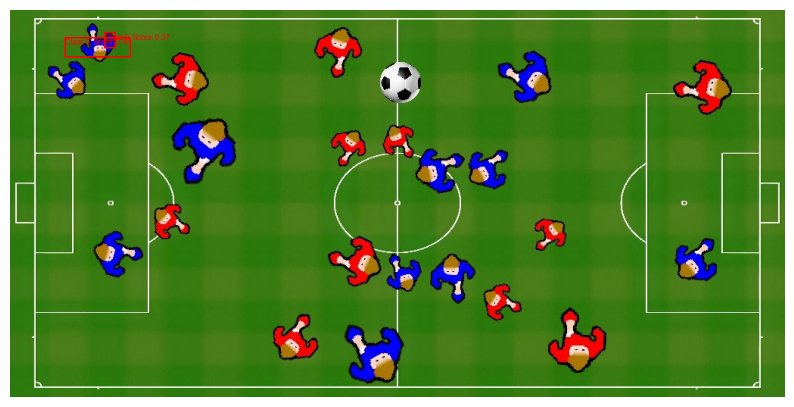

In [276]:
# Try 1

torch.save(model, 'model.pth')
model = torch.load('model.pth')
model.eval()  # Set the model to evaluation mode

from PIL import Image, ImageDraw

# Assuming you have a trained model named 'model'

def predict_and_plot(image_path, model, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path)
    original_image = image.copy()
    image = image.resize((448, 448))  # Resize the image to match the model's input size
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
    image = np.transpose(image, (2, 0, 1))  # Change the shape to (C, H, W)
    image = torch.from_numpy(image).unsqueeze(0)  # Add a batch dimension
    #print(image.shape)

    # Make predictions
    with torch.no_grad():
        predictions = model(image)

    # Get the predicted bounding boxes and class probabilities
    predictions = predictions.view(-1, 7, 7, 8)
    boxes = predictions[..., :4]
    confidence_scores = predictions[..., 4]
    class_probabilities = predictions[..., 5:]

    #print(f"predictions:\n{predictions}")
    print(f"boxes:\n{boxes}")
    print(f"confidence_scores:\n{confidence_scores}")
    print(f"class_probabilities:\n{class_probabilities}")

    # Apply confidence threshold
    conf_mask = confidence_scores > threshold
    print(f"conf_mask:\n{conf_mask}")

    # Get the detected objects
    detected_boxes = boxes[conf_mask]
    detected_classes = torch.argmax(class_probabilities[conf_mask], dim=1)
    detected_scores = confidence_scores[conf_mask]

    print(f"detected_boxes:\n{detected_boxes}")
    print(f"detected_classes:\n{detected_classes}")
    print(f"detected_scores:\n{detected_scores}")

    # Convert the bounding box coordinates to the original image scale
    original_width, original_height = original_image.size
    detected_boxes[:, 0] *= original_width / 7
    detected_boxes[:, 1] *= original_height / 7
    detected_boxes[:, 2] *= original_width / 7
    detected_boxes[:, 3] *= original_height / 7

    # Plot the detected objects on the image
    draw = ImageDraw.Draw(original_image)
    

    for box, class_label, score in zip(detected_boxes, detected_classes, detected_scores):
        x1, y1, x2, y2 = box.tolist()
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)
        draw.text((x1, y1), f"Class: {class_label}, Score: {score:.2f}", fill="red")

    # Display the image with detected objects
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/Users/kailashkumar/Downloads/week4/easy-500/0.jpg"
predict_and_plot(image_path, model, threshold=0.30)

actual predictions:
0.8054070472717285
result_dict : dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)])
result_dict : [0, 0, 0, 0, 0, 0, 0, 0]
grid_width, grid_height(146, 73)
confidence_score is : 0
actual values are (0.0, 0.0, 0.0, 0.0)
grid dimentions values are (0, 0, 146, 73)
confidence_score is : 0
actual values are (0.0, 0.0, 0.0, 0.0)
grid dimentions values are (146, 0, 292, 73)
confidence_score is : 0
actual values are (0.0, 0.0, 0.0, 0.0)
grid dimentions values are (292, 0, 438, 73)
confidence_score is : 0
actual values are (0.0, 0.0, 0.0, 0.0)
grid dimentions values are (438, 0, 584, 73)
confidence_score is : 0.3683057725429535


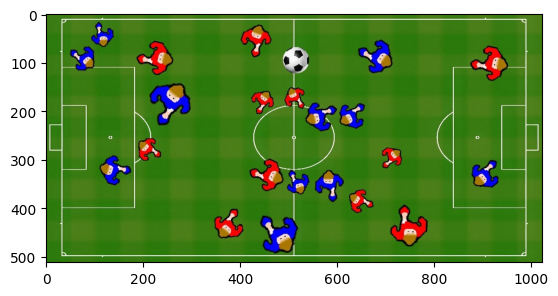

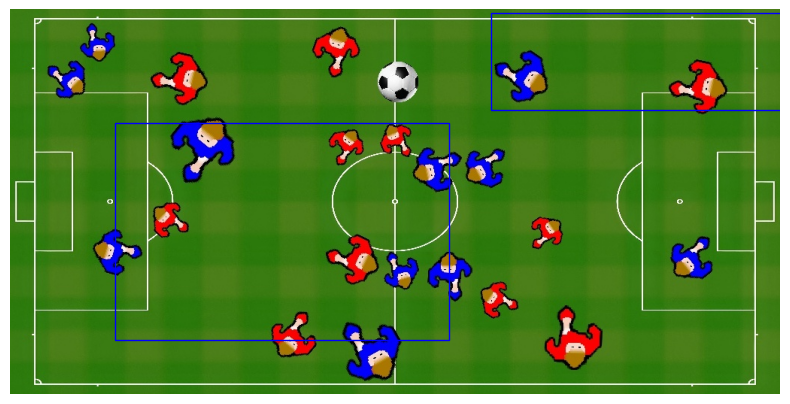

In [256]:
# attempt 2

from PIL import Image, ImageDraw
import matplotlib.patches as patches

torch.save(model, 'model.pth')
model = torch.load('model.pth')
model.eval()  # Set the model to evaluation mode


# Assuming you have a trained model named 'model'
def process_predictions(predictions, confidence_threshold):  # Assuming predictions is a tensor of shape (3, 3, 8)
    predictions = predictions.view(7, 7, 8)
    result_dict = {}
    for i in range(7):
        for j in range(7):
            if predictions[i, j, 4] >= confidence_threshold:
                result_dict[(i, j)] = predictions[i, j].tolist()
            else:
                result_dict[(i, j)] = [0] * 8
    return result_dict

def plot_grid_values(image_path, result_dict):
    
    # Load the image
    image = Image.open(image_path)
    image_width, image_height = image.size

    fig, ax = plt.subplots()
    ax.imshow(image)

    # Calculate the grid cell dimensions
    grid_width = image_width // 7
    grid_height = image_height // 7
    print(f"grid_width, grid_height{grid_width, grid_height}")

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Draw the bounding box on the image
    # draw = ImageDraw.Draw(image)

    # Iterate over each grid cell
    for i in range(7):
        for j in range(7):
            # Get the values for the current grid cell
            grid_values = result_dict.get((i, j), [0] * 8)

            # Extract the relevant values (e.g., class label, confidence score)
            class_label = grid_values[5]  # Assuming class label is at index 5
            confidence_score = grid_values[4]  # Assuming confidence score is at index 4
            print(f"confidence_score is : {confidence_score}")

            x, y, w, h = grid_values[:4]  # Assuming bounding box coordinates are at indices 0-3

            # Calculate the bounding box coordinates
            ix1 = x - w / 2
            iy1 = y - h / 2
            ix2 = x + w / 2
            iy2 = y + h / 2
            print(f"actual values are {ix1, iy1, ix2, iy2}")

            # Calculate the bounding box coordinates
            gx1 = j * grid_width
            gy1 = i * grid_height
            gx2 = (j + 1) * grid_width
            gy2 = (i + 1) * grid_height
            print(f"grid dimentions values are {gx1, gy1, gx2, gy2}")
            if confidence_score == 0:
                x1 = 0 
                y1 = 0 
                x2 = 0
                y2 = 0
            else:
                x1 = ix1 + gx1
                y1 = iy1 + gy1
                x2 = ix2 + gx2
                y2 = iy2 + gy2
            


            #draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)
            rect = patches.Rectangle((x1,y1), x2, y2, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

            # Add the class label and confidence score as text
            text = f"Class: {class_label}, Score: {confidence_score:.2f}"
            draw.text((x1, y1), text, fill="red")
            #print("________loop done ______")

    # Display the image with bounding boxes and labels
    ax.axis("off")
    plt.tight_layout()
    plt.show()

def predict_and_plot(image_path, model, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path)
    original_image = image.copy()
    image = image.resize((448, 448))  # Resize the image to match the model's input size
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
    image = np.transpose(image, (2, 0, 1))  # Change the shape to (C, H, W)
    image = torch.from_numpy(image).unsqueeze(0)  # Add a batch dimension
    #print(image.shape)

    # Make predictions
    with torch.no_grad():
        predictions = model(image)

    # Get the predicted bounding boxes and class probabilities
    predictions = predictions.view(-1, 7, 7, 8)
    print(f"actual predictions:\n{predictions[0][0][0][0]}")

    boxes = predictions[..., :5]
    confidence_scores = predictions[..., 4]
    class_probabilities = predictions[..., 5:]

   
    #print(f"boxes:\n{boxes}")
    #print(f"confidence_scores:\n{confidence_scores}")
    #print(f"class_probabilities:\n{class_probabilities}")

    # Convert the bounding box coordinates to the original image scale
    original_width, original_height = original_image.size
    predictions[..., 0] *= original_width / 7
    predictions[..., 1] *= original_height / 7
    predictions[..., 2] *= original_width / 7
    predictions[..., 3] *= original_height / 7

    #print(f"modified predictions:\n{predictions[0][0][0][0]}")
    result_dict_3 = process_predictions(predictions, threshold)

    print(f"result_dict : {result_dict_3.keys()}")
    print(f"result_dict : {result_dict_3[(0,1)]}")

    plot_grid_values(image_path, result_dict_3)


# Example usage
image_path = "/Users/kailashkumar/Downloads/week4/easy-500/0.jpg"
predict_and_plot(image_path, model, threshold=0.30)


In [215]:
import torch

def process_predictions(predictions, confidence_threshold):
    # Assuming predictions is a tensor of shape (3, 3, 8)
    result_dict = {}
    for i in range(3):
        for j in range(3):
            if predictions[i, j, 4] >= confidence_threshold:
                result_dict[(i, j)] = predictions[i, j].tolist()
            else:
                result_dict[(i, j)] = [0] * 8
    return result_dict

# Example usage
predictions = torch.rand(3, 3, 8)  # Replace with your actual predictions tensor
print(predictions)
confidence_threshold = 0.5

result_dict = process_predictions(predictions, confidence_threshold)
print(result_dict.keys())

tensor([[[9.4773e-01, 8.6243e-01, 2.9022e-01, 2.1073e-02, 8.0256e-01,
          6.4468e-01, 8.7313e-01, 1.7445e-01],
         [3.3692e-01, 5.0649e-01, 8.6266e-01, 8.5971e-01, 4.5600e-01,
          5.7533e-01, 2.4879e-01, 6.8220e-02],
         [5.9771e-01, 3.8188e-01, 3.1895e-01, 1.2968e-01, 9.7677e-01,
          1.6083e-02, 7.3496e-01, 3.9540e-01]],

        [[7.4592e-01, 5.1688e-01, 8.5249e-01, 4.9190e-01, 7.9218e-01,
          7.1469e-01, 7.7486e-01, 9.0204e-01],
         [2.1063e-01, 8.3189e-01, 3.4010e-01, 9.7495e-01, 6.8995e-01,
          7.8252e-01, 7.4213e-02, 2.8526e-01],
         [6.7974e-01, 2.1916e-01, 9.8300e-01, 2.8716e-01, 9.9913e-01,
          2.5258e-01, 3.0928e-01, 8.3812e-01]],

        [[7.4358e-01, 4.1178e-01, 6.2040e-01, 9.9115e-01, 4.5921e-02,
          8.5552e-01, 6.5128e-01, 2.9073e-01],
         [6.2386e-01, 7.6466e-01, 1.7760e-02, 9.0399e-01, 6.9862e-01,
          5.5550e-01, 5.4190e-02, 9.0093e-01],
         [7.9658e-01, 4.2537e-01, 7.8382e-01, 1.8849e-01, 3.

dict_keys([])


KeyError: (0, 0)

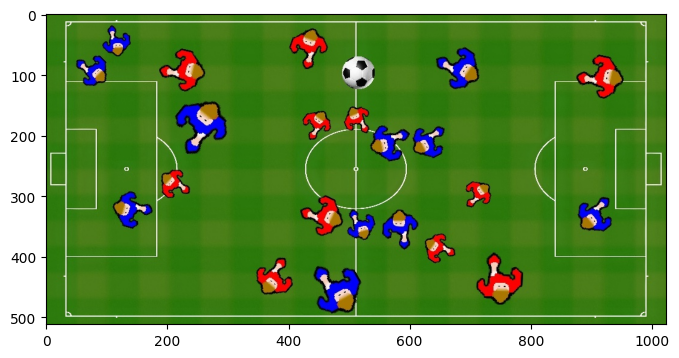